In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [22]:
# !pip install pyldavis
# !pip install spacy

In [28]:
from collections import Counter
from pathlib import Path
import logging
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

import pyLDAvis
from pyLDAvis.gensim_models import prepare
from tqdm import tqdm

In [6]:
sns.set_style('white')
pyLDAvis.enable_notebook()

In [7]:
STOP_WORDS_URL = 'http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words'
stop_words = set(pd.read_csv(STOP_WORDS_URL,
                             header=None,
                             squeeze=True).tolist())

## Helper functions

In [45]:
def show_word_list(model, corpus, top=10, save=False, coherence="u_mass"):
    top_topics = model.top_topics(corpus=corpus, coherence=coherence, topn=top * 2)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics * 1.2, 5))
    sns.heatmap(
        pd.DataFrame(probs).T,
        annot=pd.DataFrame(words).T,
        fmt="",
        ax=ax,
        cmap="Blues",
        cbar=False,
    )
    fig.tight_layout()
    if save:
        fig.savefig(f"fin_news_wordlist_{top}", dpi=300)


def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence="u_mass", topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    title = f"# Words with Probability > {cutoff:.2%}"
    (word_lists.loc[:, order] > cutoff).sum().reset_index(drop=True).plot.bar(
        title=title, ax=axes[1]
    )

    umass = model.top_topics(corpus=corpus, coherence="u_mass", topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title="Topic Coherence", ax=axes[0])
    fig.tight_layout()
    fig.savefig(f"fin_news_coherence_{top}", dpi=300)


def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat(
        [
            pd.DataFrame(doc_topic, columns=["topicid", "weight"]).assign(doc=i)
            for i, doc_topic in enumerate(doc_topics)
        ]
    )

    for topicid, data in df.groupby("topicid"):
        print(
            topicid, docs[int(data.sort_values("weight", ascending=False).iloc[0].doc)]
        )
        print(pd.DataFrame(lda.show_topic(topicid=topicid)))
        
def read_articles(data_path,limit=10000):
    articles = []
    counter = Counter()
    #bad practice
    for f in tqdm(list(data_path.glob('*/**/*.json'))[:limit]):
        article = json.load(f.open(encoding="utf8"))
        if article['thread']['section_title'] in set(section_titles):
            text = article['text'].lower().split()
            counter.update(text)
            articles.append(' '.join([t for t in text if t not in stop_words]))
    return articles, counter

def clean_doc(d):
    doc = []
    for t in d:
        if not any(
            [
                t.is_stop,
                t.is_digit,
                not t.is_alpha,
                t.is_punct,
                t.is_space,
                t.lemma_ == "-PRON-",
            ]
        ):
            doc.append(t.lemma_)
    return " ".join(doc)

def preprocess(articles):
    iter_articles = (article for article in articles)
    clean_articles = []
    for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=8), 1):
        if i % 1000 == 0:
            print(f"{i / len(articles):.2%}", end=" ", flush=True)
        clean_articles.append(clean_doc(doc))
    return clean_articles


def eval_lda_model(ntopics, model, corpus, tokens):
    show_word_list(model=model, corpus=corpus, top=ntopics, save=True)
    show_coherence(model=model, corpus=corpus, tokens=tokens, top=ntopics)
    vis = prepare(model, corpus, dictionary, mds="tsne")
    pyLDAvis.save_html(vis, f"lda_{ntopics}.html")
    return 2 ** (-model.log_perplexity(corpus))


In [18]:
data_path = Path( 'data', 'us-financial-news')


In [19]:
section_titles = ['Press Releases - CNBC',
                  'Reuters: Company News',
                  'Reuters: World News',
                  'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate',
                  'Top News and Analysis (pro)',
                  'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News',
                  'Reuters: Technology News']

In [36]:
articles, counter = read_articles(data_path)
print(f'Done loading {len(articles):,.0f} articles')

100%|██████████| 10000/10000 [00:02<00:00, 3846.39it/s]

Done loading 5,185 articles


In [37]:
most_common = (pd.DataFrame(counter.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

## Preprocess

In [38]:
results_path = Path('results', 'financial_news')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [42]:
# !python -m spacy download en_core_web_sm

In [43]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 6000000
nlp.disable_pipes('ner')

C:\Users\Lion\anaconda3\lib\site-packages\spacy\language.py:1035: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['ner']

In [46]:
clean_articles = preprocess(articles)


19.29% 38.57% 57.86% 77.15% 96.43% 

In [48]:
clean_path = results_path / 'clean_text'
clean_path.write_text('\n'.join(clean_articles),encoding="utf8")

8839413

In [50]:
docs = clean_path.read_text(encoding="utf8").split('\n')
len(docs)

5185

## Explore

In [51]:
article_length, token_count = [], Counter()
for i, doc in enumerate(docs, 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    d = doc.lower().split()
    article_length.append(len(d))
    token_count.update(d)

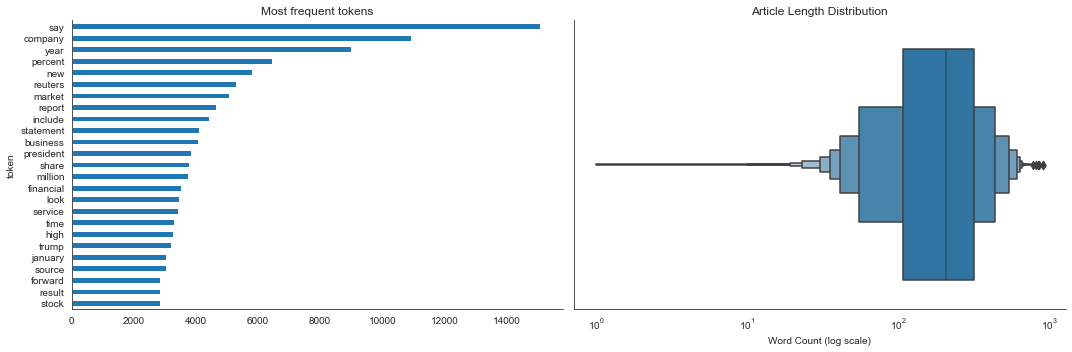

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:25]
 .sort_values()
 .plot
 .barh(ax=axes[0], title='Most frequent tokens'))
sns.boxenplot(x=pd.Series(article_length), ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word Count (log scale)')
axes[1].set_title('Article Length Distribution')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'fn_explore', dpi=300);

In [53]:
pd.Series(article_length).describe(percentiles=np.arange(.1, 1.0, .1))


count    5185.000000
mean      232.975313
std       158.952747
min         1.000000
10%        49.000000
20%        85.000000
30%       128.000000
40%       166.000000
50%       205.000000
60%       245.000000
70%       287.000000
80%       356.200000
90%       473.000000
max       908.000000
dtype: float64

In [54]:
docs = [x.lower() for x in docs]


## Vocab Params

In [55]:
min_df = .005
max_df = .1
ngram_range = (1, 1)
binary = False

In [56]:
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=ngram_range,
                             binary=binary)
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()
dtm.shape

(5185, 3600)

In [57]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

## LDA

In [58]:
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.DEBUG)
logging.root.level = logging.DEBUG

In [59]:
num_topics = [5, 10, 15, 20]

for topics in num_topics:
    print(topics)
    lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=topics,
                     chunksize=len(docs),
                     update_every=1,
                     alpha='auto',                     # a-priori belief for the each topics' probability
                     eta='auto',                       # a-priori belief on word probability
                     decay=0.5,                        # percentage of previous lambda value forgotten
                     offset=1.0,
                     eval_every=1,
                     passes=10,
                     iterations=50,
                     gamma_threshold=0.001,
                     minimum_probability=0.01,         # filter topics with lower probability
                     minimum_phi_value=0.01,           # lower bound on term probabilities
                     random_state=42)
    lda_model.save((results_path / f'model_{topics}').as_posix())

5
10
15
20


## Evaluate

5


C:\Users\Lion\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Lion\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


10


C:\Users\Lion\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Lion\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


15


C:\Users\Lion\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Lion\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


20


C:\Users\Lion\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Lion\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


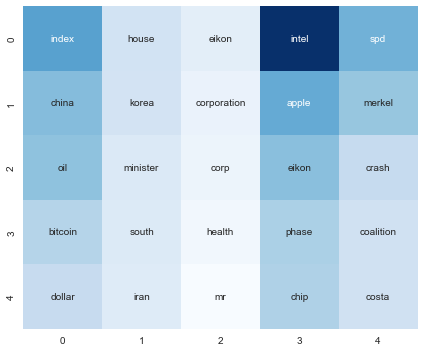

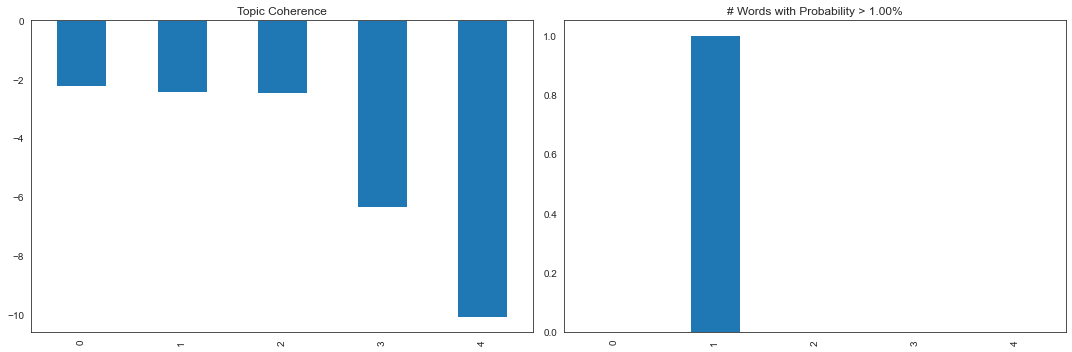

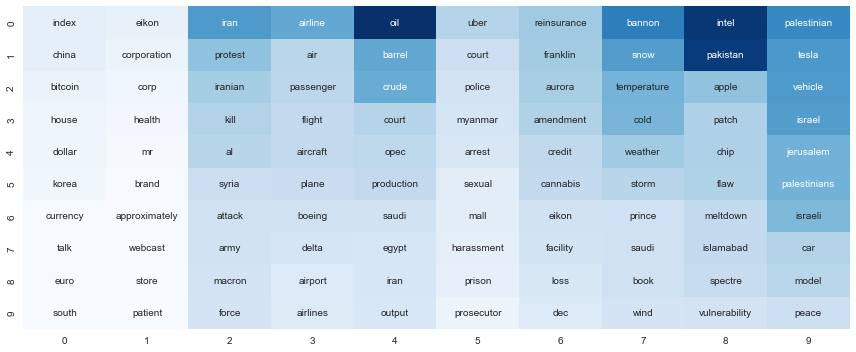

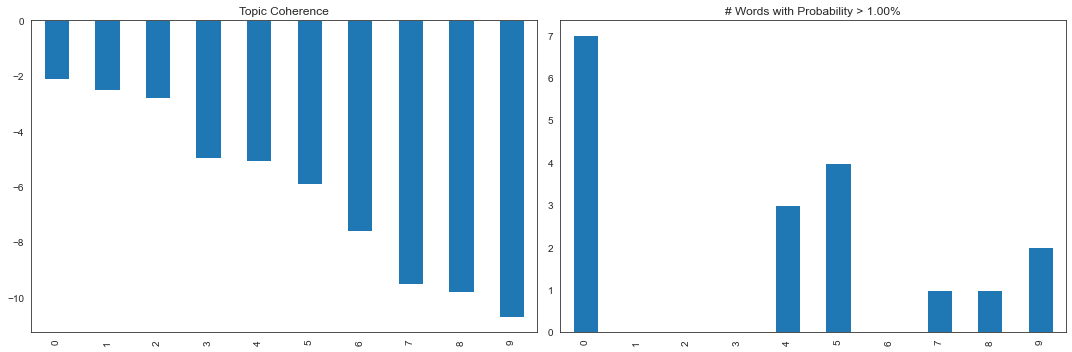

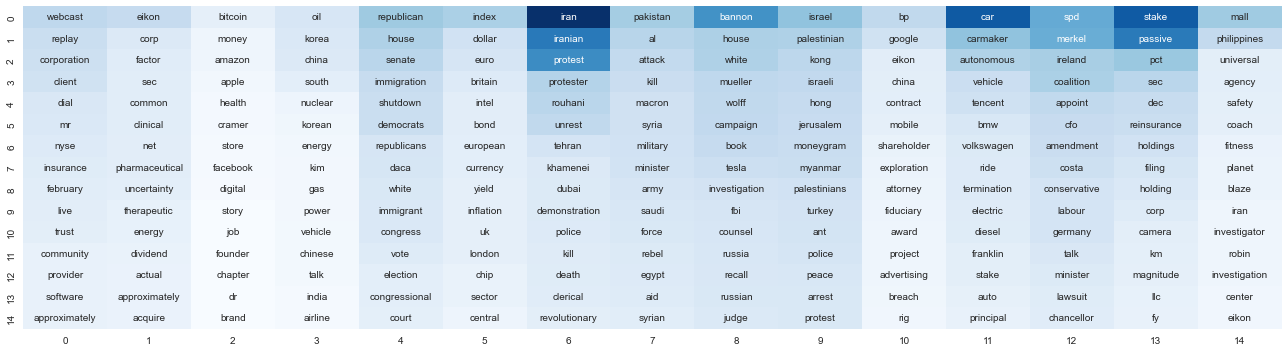

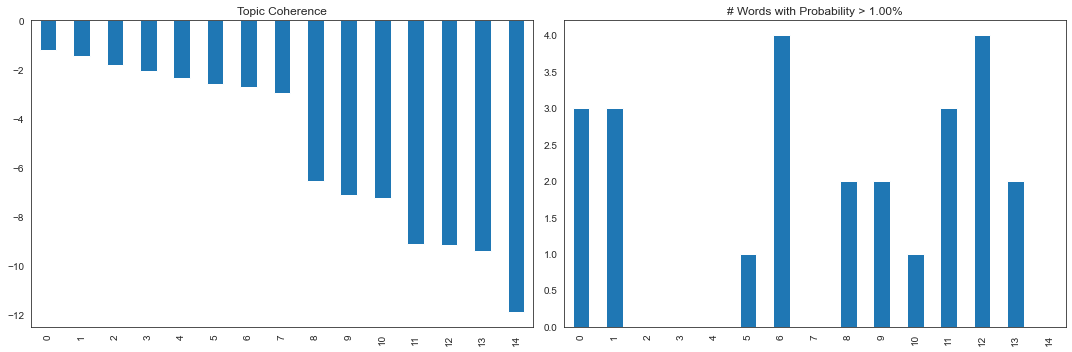

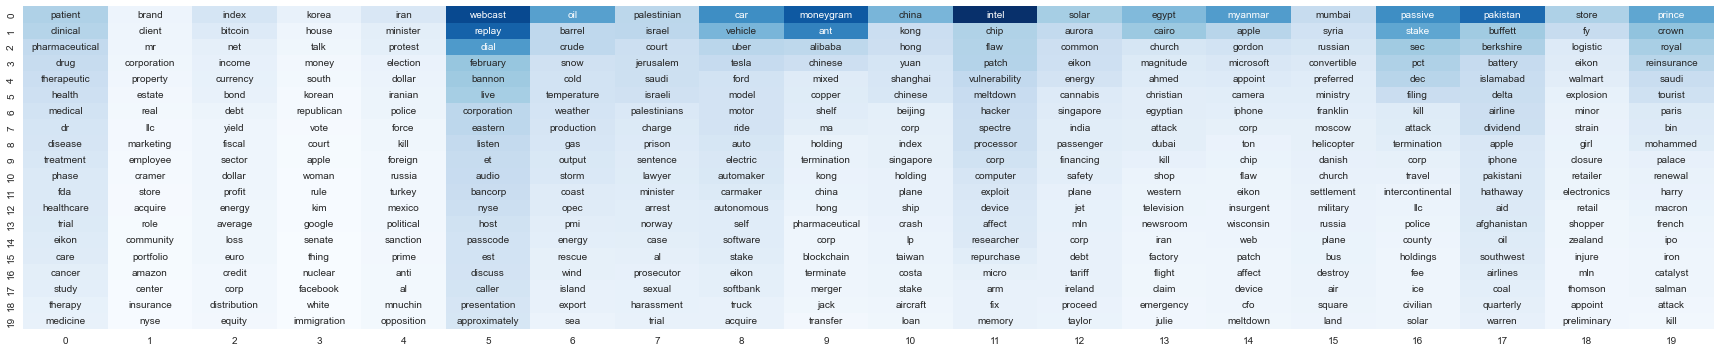

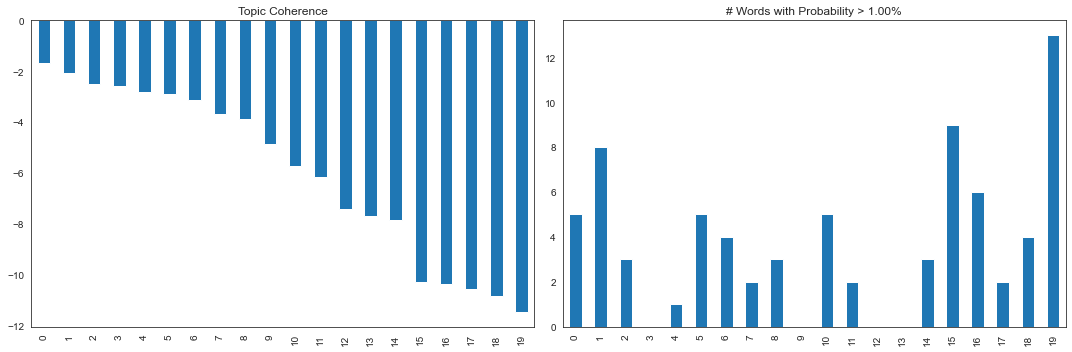

In [60]:
lda_models = {}
perplexity ={}
for ntopics in num_topics:
    print(ntopics)
    lda_models[ntopics] = LdaModel.load((results_path / f'model_{ntopics}').as_posix())
    perplexity[ntopics] = eval_lda_model(ntopics=ntopics, model=lda_models[ntopics],corpus=corpus, tokens=tokens)

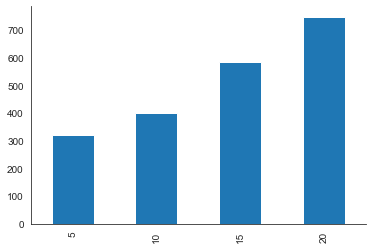

In [61]:
pd.Series(perplexity).plot.bar()
sns.despine();